We will train classification models (Logistic Regression and Naive Bayes) on the preprocessed dataset and evaluate their performance on training, validation, and test sets.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [40]:
# Random State
RNG = 42

In [41]:
# Step 1: Load the data
df = pd.read_csv("../data/train.csv")

In [42]:
from project.src.utils import classify_price

# Step 2: Process Data
# Add PriceCategory column
df['PriceCategory'] = df['SalePrice'].apply(classify_price)

# Remove Id and SalePrice columns
df = df.drop(['Id', 'SalePrice'], axis=1)

# Separate features and target
X = df.drop('PriceCategory', axis=1)
y = df['PriceCategory']

In [43]:
# Handle numeric and categorical features differently
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [44]:
# Pre-processing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [45]:
# Step 3: Split Data into Train (80%), Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG, stratify=y
)

In [46]:
# Step 4: Train Naive Bayes Model and apply 4-fold cross-validation
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])
nb_pipeline.fit(X_train, y_train)
cv_scores_nb = cross_val_score(nb_pipeline, X_train, y_train, cv=4, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores_nb}")
print(f"Mean CV accuracy: {cv_scores_nb.mean():.4f}")

Cross-validation scores: [0.7260274  0.76712329 0.70547945 0.76027397]
Mean CV accuracy: 0.7397



Training accuracy: 0.7731
Test accuracy: 0.7637

Confusion Matrix (Test Set):
[[89  8  0]
 [34 47 18]
 [ 0  9 87]]

Classes: 0 - Low, 1 - Medium, 2 - High


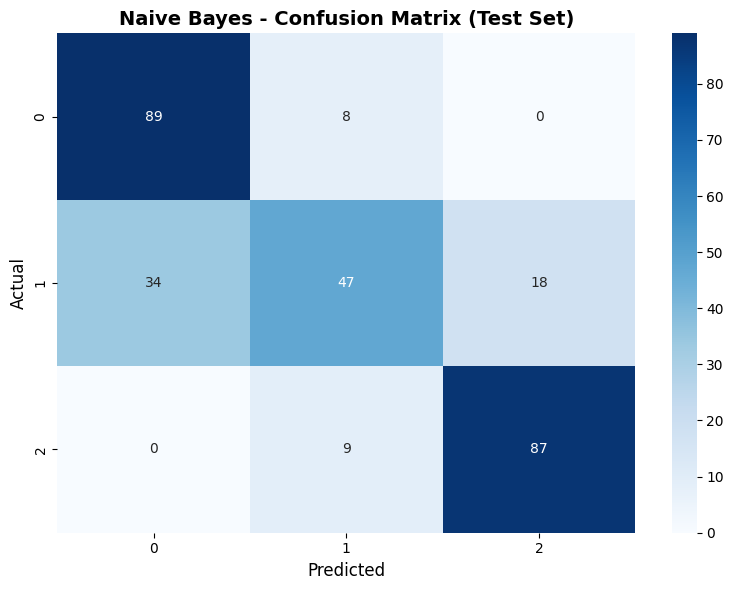

In [47]:
# Step 5: Evaluate Model Accuracy
y_train_pred_nb = nb_pipeline.predict(X_train)
train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
print(f"\nTraining accuracy: {train_accuracy_nb:.4f}")

y_test_pred_nb = nb_pipeline.predict(X_test)
test_accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
print(f"Test accuracy: {test_accuracy_nb:.4f}")

print("\nConfusion Matrix (Test Set):")
cm_nb = confusion_matrix(y_test, y_test_pred_nb)
print(cm_nb)
print("\nClasses: 0 - Low, 1 - Medium, 2 - High")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb_pipeline.classes_,
            yticklabels=nb_pipeline.classes_)
plt.title('Naive Bayes - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

In [48]:
# Step 6: Train Logistic Regression Model and apply 4-fold cross-validation
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=RNG))
])
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFull...
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

Cross-validation scores: [0.78082192 0.78424658 0.81164384 0.78424658]
Mean CV accuracy: 0.7902 (+/- 0.0124)

Training accuracy: 0.9786
Test accuracy: 0.7979

Confusion Matrix (Test Set):
[[80 17  0]
 [16 75  8]
 [ 0 18 78]]

Classes: 0 - Low, 1 - Medium, 2 - High


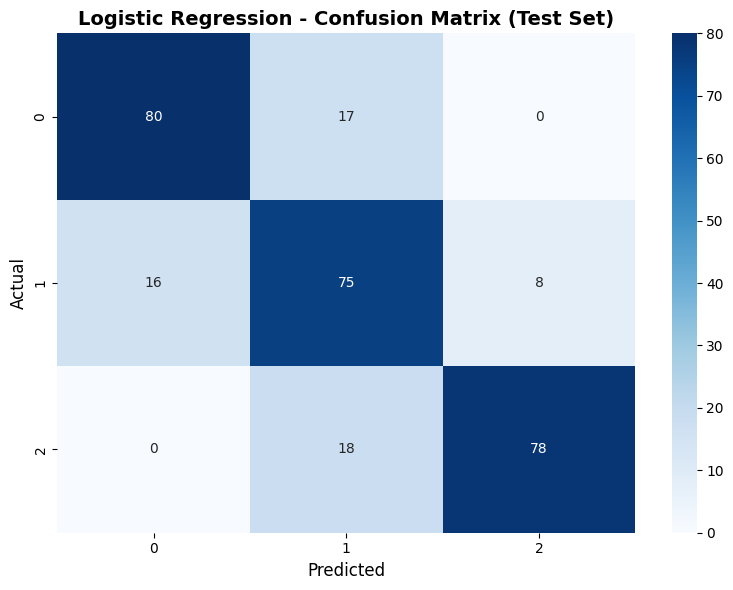

In [49]:
# Step 7: Evaluate Model Accuracy
cv_scores_lr = cross_val_score(lr_pipeline, X_train, y_train, cv=4, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores_lr}")
print(f"Mean CV accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})")

y_train_pred_lr = lr_pipeline.predict(X_train)
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
print(f"\nTraining accuracy: {train_accuracy_lr:.4f}")

y_test_pred_lr = lr_pipeline.predict(X_test)
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
print(f"Test accuracy: {test_accuracy_lr:.4f}")

print("\nConfusion Matrix (Test Set):")
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
print(cm_lr)
print("\nClasses: 0 - Low, 1 - Medium, 2 - High")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=lr_pipeline.classes_,
            yticklabels=lr_pipeline.classes_)
plt.title('Logistic Regression - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

In [50]:
# Summary
print(f"\nNaive Bayes:")
print(f"  - Mean CV Accuracy: {cv_scores_nb.mean():.4f}")
print(f"  - Training Accuracy: {train_accuracy_nb:.4f}")
print(f"  - Test Accuracy: {test_accuracy_nb:.4f}")

print(f"\nLogistic Regression:")
print(f"  - Mean CV Accuracy: {cv_scores_lr.mean():.4f}")
print(f"  - Training Accuracy: {train_accuracy_lr:.4f}")
print(f"  - Test Accuracy: {test_accuracy_lr:.4f}")


Naive Bayes:
  - Mean CV Accuracy: 0.7397
  - Training Accuracy: 0.7731
  - Test Accuracy: 0.7637

Logistic Regression:
  - Mean CV Accuracy: 0.7902
  - Training Accuracy: 0.9786
  - Test Accuracy: 0.7979
